# Clasificar el nivel de gasto del cliente

## Objetivo

El objetivo del modelo es clasificar a cada cliente en dos categorías según su nivel de gasto:

Bajo: importe < 5.000

Alto: importe ≥ 5.000

Este es un problema de clasificación binaria, ya que se busca asignar cada registro a una de dos clases posibles.

## Algoritmo elegido: Regresion logística

Se selecciona el algoritmo de Regresión Logística porque está diseñado específicamente para problemas de clasificación binaria.

## Variables

### variable de salida (y) 


La variable objetivo será una variable binaria creada a partir del importe:

y= ventas_altas

y = 1 → Cliente de gasto alto (importe ≥ 5000)

y = 0 → Cliente de gasto bajo (importe < 5000)

### Variables de entrada (X)

Están compuestas por todas las características independientes que pueden influir en la predicción de la clase.

X: precio_unitario, cantidad, categoria, medio_pago, ciudad

## Métricas de evaluación

### Accuracy (Exactitud)

Porcentaje de predicciones correctas sobre el total.

### Matriz de confusión

Permite ver cuántos casos fueron correctamente y incorrectamente clasificados.

#### Librerías

In [23]:
%%capture
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%pip install scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler

In [24]:
datos = pd.read_csv('datasets/dataset_unificado/ventas_completo.csv')

In [25]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_venta         339 non-null    int64  
 1   fecha            339 non-null    object 
 2   id_cliente       339 non-null    int64  
 3   medio_pago       339 non-null    object 
 4   nombre_cliente   339 non-null    object 
 5   email            339 non-null    object 
 6   ciudad           339 non-null    object 
 7   fecha_alta       339 non-null    object 
 8   id_producto      339 non-null    int64  
 9   cantidad         339 non-null    int64  
 10  importe          339 non-null    float64
 11  nombre_producto  339 non-null    object 
 12  categoria        339 non-null    object 
 13  precio_unitario  339 non-null    float64
dtypes: float64(2), int64(4), object(8)
memory usage: 37.2+ KB


In [26]:
datos.head()

,id_venta,fecha,id_cliente,medio_pago,nombre_cliente,email,ciudad,fecha_alta,id_producto,cantidad,importe,nombre_producto,categoria,precio_unitario
0,1,2024-06-19,62,tarjeta,Guadalupe Romero,guadalupe.romero@mail.com,Carlos Paz,2023-03-03,90,1,2902.0,Toallas Húmedas x50,Limpieza,2902.0
1,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,22,1,2069.0,Medialunas de Manteca,Alimentos,2069.0
2,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,39,5,2345.0,Helado Vainilla 1L,Alimentos,469.0
3,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,70,2,8122.0,Fernet 750ml,Alimentos,4061.0
4,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,79,4,9680.0,Hamburguesas Congeladas x4,Alimentos,2420.0


Importe es la variable objetivo

In [27]:
datos['ventas_altas'] = np.where(datos.importe < 5000, 0, 1) # se pone 0 si es menor a 5000 y 1 si es mayor a 5000
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'importe')

In [28]:
datos.head()

,id_venta,fecha,id_cliente,medio_pago,nombre_cliente,email,ciudad,fecha_alta,id_producto,cantidad,nombre_producto,categoria,precio_unitario,ventas_altas
0,1,2024-06-19,62,tarjeta,Guadalupe Romero,guadalupe.romero@mail.com,Carlos Paz,2023-03-03,90,1,Toallas Húmedas x50,Limpieza,2902.0,0
1,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,22,1,Medialunas de Manteca,Alimentos,2069.0,0
2,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,39,5,Helado Vainilla 1L,Alimentos,469.0,0
3,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,70,2,Fernet 750ml,Alimentos,4061.0,1
4,2,2024-03-17,49,qr,Olivia Gomez,olivia.gomez@mail.com,Rio Cuarto,2023-02-18,79,4,Hamburguesas Congeladas x4,Alimentos,2420.0,1


Si bien usamos una BD limpia, revisamos que no haya valores nulos para evitar errores

In [29]:
datos.isnull().sum()

id_venta           0
fecha              0
id_cliente         0
medio_pago         0
nombre_cliente     0
email              0
ciudad             0
fecha_alta         0
id_producto        0
cantidad           0
nombre_producto    0
categoria          0
precio_unitario    0
ventas_altas       0
dtype: int64

In [30]:
# Eliminar columnas que causan ruido o tienen demasiada cardinalidad
cols_to_drop = ['id_venta', 'id_cliente' , 'id_producto', 'nombre_cliente', 'email', 'fecha', 'fecha_alta','nombre_producto']
datos_limpios = datos.drop(columns=cols_to_drop)

#### División de los datos: entrenamiento (80%) vs. test (20%)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123 # semilla para la aleatoriedad
                                    )


### Encodear las columnas categóricas

In [32]:
# One-hot-encoding de las variables categóricas, es decir pasamos las variables categoricas a variables numericas
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = ['categoria', 'medio_pago', 'ciudad']
numeric_cols = ['cantidad', 'precio_unitario']

# Crear el Transformador con DOS ramas (pipelines)
preprocessor = ColumnTransformer(
    transformers=[
        # Rama 1: Para números -> Aplica Escalado Estándar
        ('num', StandardScaler(), numeric_cols),
        
        # Rama 2: Para texto -> Aplica OneHotEncoding
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    # remainder='drop' asegura que si se nos coló alguna columna extra, la ignore
    remainder='drop' 
)

In [33]:
# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [34]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
# Usar get_feature_names_out() en lugar de get_feature_names()


encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_labels = numeric_cols + list(encoded_cat_names)

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=all_labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=all_labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cantidad                  254 non-null    float64
 1   precio_unitario           254 non-null    float64
 2   categoria_Alimentos       254 non-null    float64
 3   categoria_Limpieza        254 non-null    float64
 4   medio_pago_efectivo       254 non-null    float64
 5   medio_pago_qr             254 non-null    float64
 6   medio_pago_tarjeta        254 non-null    float64
 7   medio_pago_transferencia  254 non-null    float64
 8   ciudad_Alta Gracia        254 non-null    float64
 9   ciudad_Carlos Paz         254 non-null    float64
 10  ciudad_Cordoba            254 non-null    float64
 11  ciudad_Mendiolaza         254 non-null    float64
 12  ciudad_Rio Cuarto         254 non-null    float64
 13  ciudad_Villa Maria        254 non-null    float64
dtypes: float64

###  Creamos el modelo y lo entrenamos con nuestros datos

In [35]:
modelo_logistico = LogisticRegression(random_state=42, max_iter=1000)

# Entrenamiento del modelo

modelo_logistico.fit(X_train_prep, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Predecimos y evaluamos

In [36]:
# Predicciones
predicciones_logisticas = modelo_logistico.predict(X_test_prep)

# Evaluación
exactitud = accuracy_score(y_test, predicciones_logisticas)
cm = confusion_matrix(y_test, predicciones_logisticas)

print("Matriz de Confusión:\n", cm)

Matriz de Confusión:
 [[30  6]
 [ 2 47]]


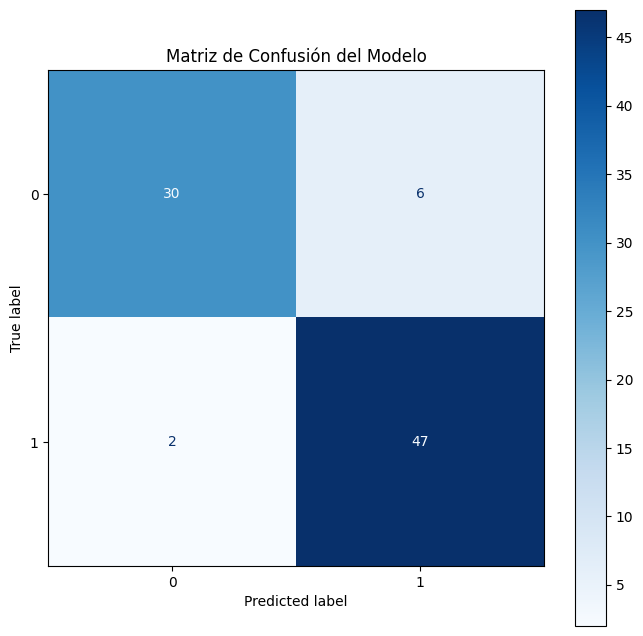

In [37]:
etiquetas_display = [0, 1] # Ejemplo para un problema binario

# 2. Crear el objeto de visualización
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=etiquetas_display
)

# 3. Plotear el gráfico
fig, ax = plt.subplots(figsize=(8, 8)) # Ajusta el tamaño
disp.plot(
    cmap=plt.cm.Blues, # Esquema de color (ej. 'Blues', 'viridis')
    ax=ax,
    values_format='d' # Formato para mostrar números enteros
) 
plt.title('Matriz de Confusión del Modelo')
plt.show() 

In [38]:
print(f"\nExactitud (Accuracy) en el test: {exactitud:.4f}")


Exactitud (Accuracy) en el test: 0.9059


In [39]:
# 1. Calcular Precisión
precision = precision_score(y_test, predicciones_logisticas)

# 2. Calcular Exhaustividad (Recall)
recall = recall_score(y_test, predicciones_logisticas)

print(f"Precisión: {precision:.4f}")
print(f"Exhaustividad (Recall): {recall:.4f}")

# OPCIONAL: Reporte Completo (muy útil)
# Muestra Precision, Recall y F1-score para cada clase:
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, predicciones_logisticas))

Precisión: 0.8868
Exhaustividad (Recall): 0.9592

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        36
           1       0.89      0.96      0.92        49

    accuracy                           0.91        85
   macro avg       0.91      0.90      0.90        85
weighted avg       0.91      0.91      0.90        85



Precisión: 

* De todas las instancias que el modelo predijo como Clase 0, el 94% fueron realmente Clase 0. 
* De todas las instancias que el modelo predijo como Clase 1, el 89% fueron realmente Clase 1.

Exhaustividad (Recall)

* De todas las instancias que realmente eran Clase 0, el modelo solo detectó el 83%. Este es el punto menos fuerte
* De todas las instancias que realmente eran Clase 1, el modelo detectó el 96%. El modelo es muy bueno detectando clientes que gastan mucho

Conclusion:

El modelo prefiere clasificar a algunos clientes bajos como altos antes que perderse a un solo cliente alto real.

El único "riesgo" de este modelo es que trates como VIP(gastos grandes) a algunos clientes que no lo son.

Generalmente, esto es bueno para el negocio: es mejor tratar bien a un cliente normal por error, que ignorar a un cliente VIP por error.